In [75]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
blastchar_telco_customer_churn_path = kagglehub.dataset_download('blastchar/telco-customer-churn')

print('Data source import complete.')


Data source import complete.


In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


# **Libraries**

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

# **Exploratory Data Analysis (EDA) & Dataset Overview**

In [78]:
#loading data
df = pd.read_csv('/content/Telco-Customer-Churn.csv')

In [79]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [81]:
df['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869


# **Data Cleaning & Type Conversion**

In [82]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [83]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)

In [84]:
# Check missing values
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [85]:
# Drop rows with missing TotalCharges
df = df.dropna(subset=['TotalCharges'])

# **Feature Classification: Numerical vs Categorical**

In [86]:
# Exclude target and ID
df_features = df.drop(['customerID', 'Churn'], axis=1)

# Separate numerical and categorical features
numerical_features = df_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_features.select_dtypes(include=['object']).columns.tolist()


In [87]:
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


# **Outlier Analysis and Handling**

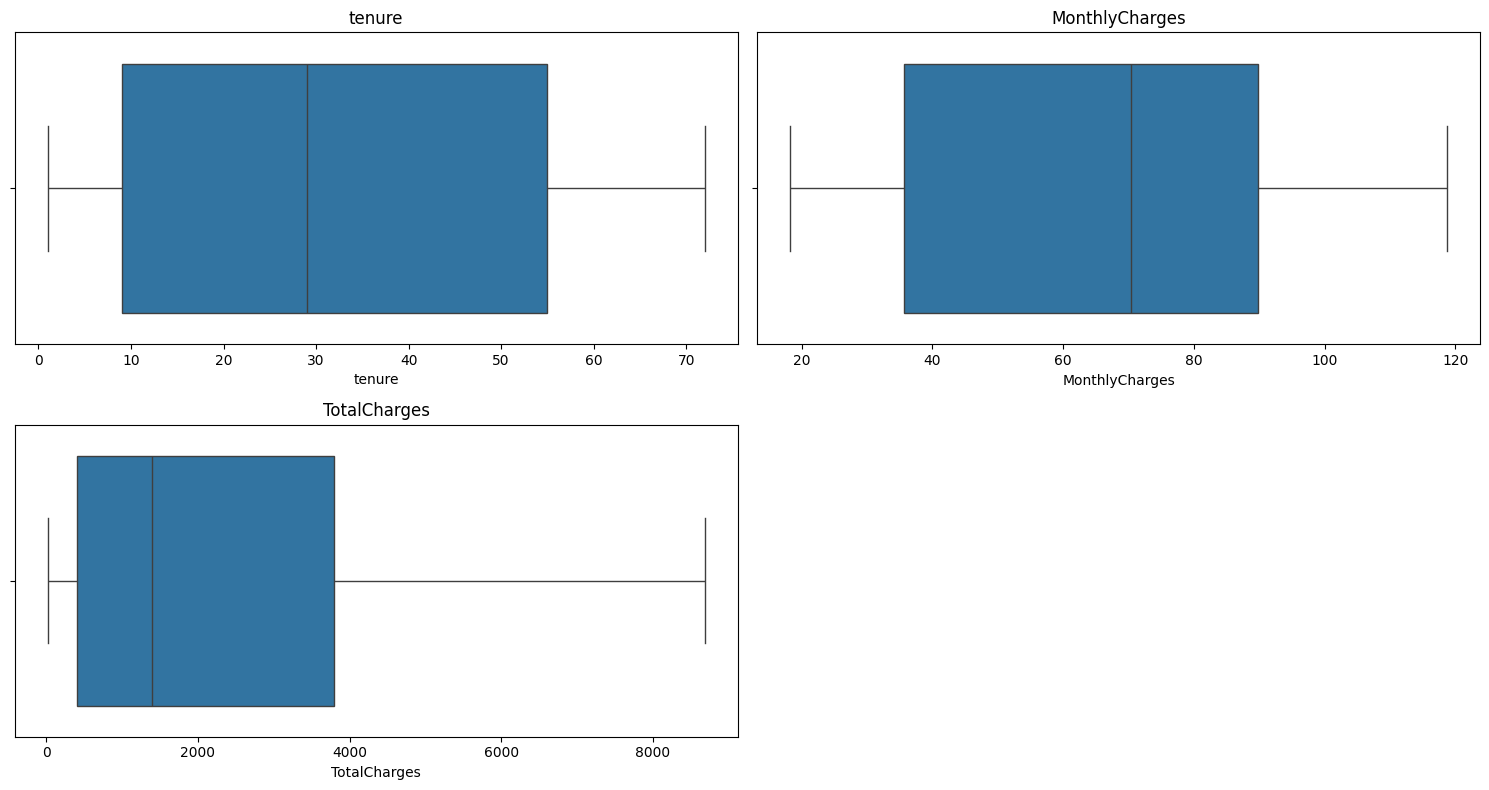

In [88]:
# Plot boxplots for outlier detection
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_features):
    plt.subplot(2, int(len(numerical_features)/2)+1, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

tenure:
  Lower limit (5th percentile): 1.00
  Upper limit (95th percentile): 72.00
  Values capped: 0

MonthlyCharges:
  Lower limit (5th percentile): 19.65
  Upper limit (95th percentile): 107.42
  Values capped: 669

TotalCharges:
  Lower limit (5th percentile): 49.60
  Upper limit (95th percentile): 6923.59
  Values capped: 704



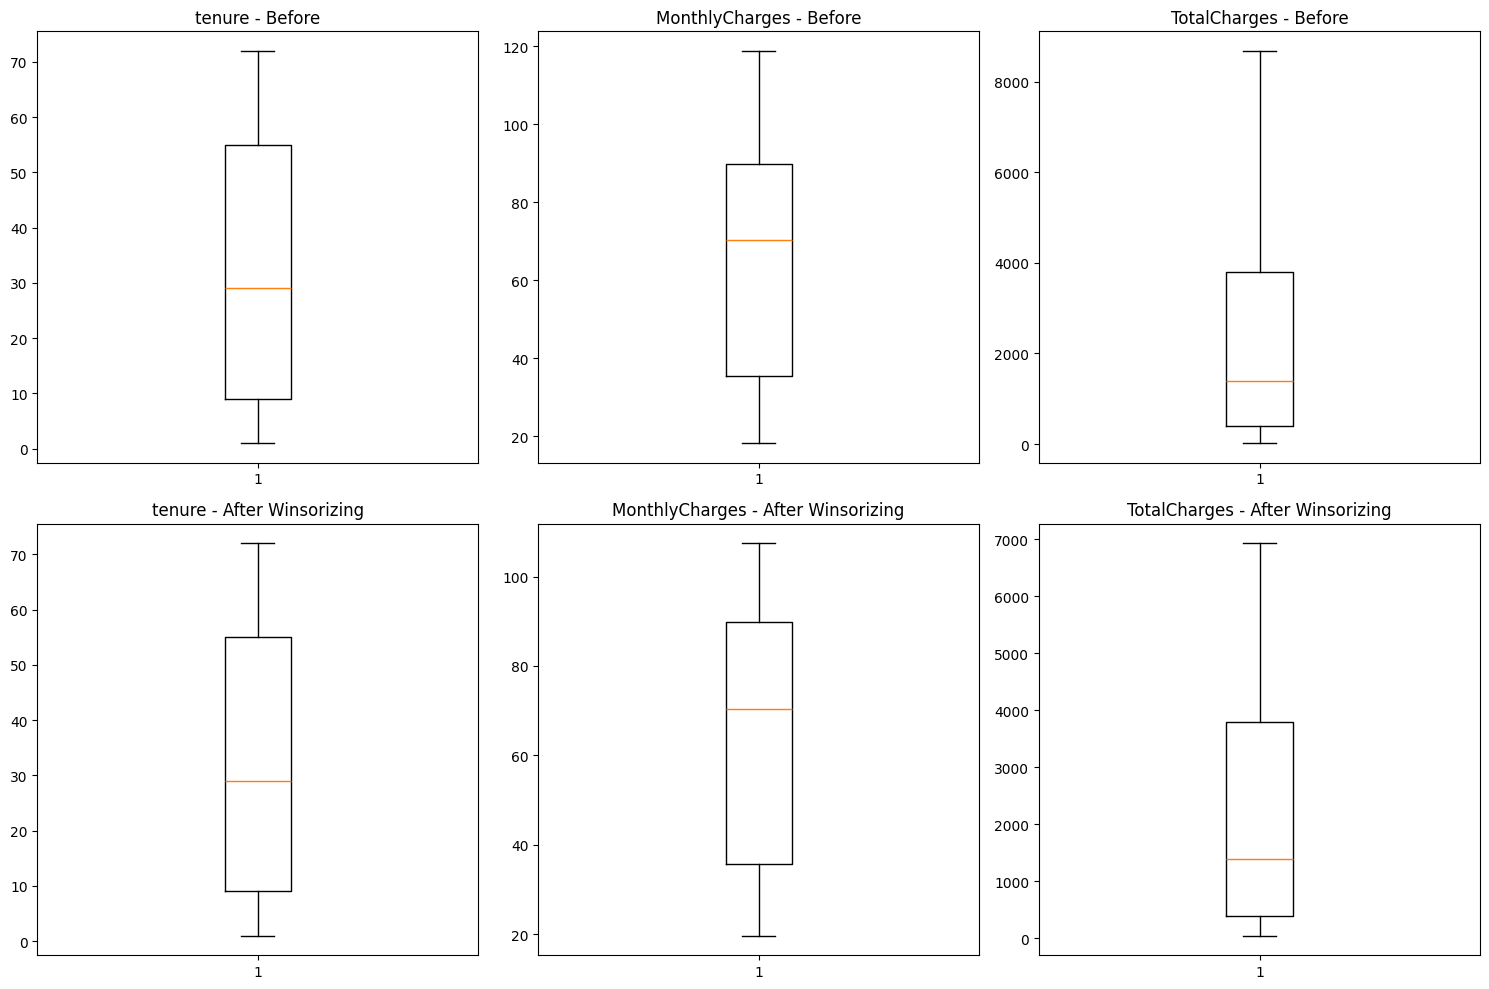

In [89]:
# Outlier Handling - Winsorizing Method
def handle_outliers_winsorizing(df, columns, lower_percentile=0.05, upper_percentile=0.95):
    df_cleaned = df.copy()

    for col in columns:
        lower_limit = df[col].quantile(lower_percentile)
        upper_limit = df[col].quantile(upper_percentile)

        df_cleaned[col] = np.where(df_cleaned[col] < lower_limit, lower_limit, df_cleaned[col])
        df_cleaned[col] = np.where(df_cleaned[col] > upper_limit, upper_limit, df_cleaned[col])

        print(f"{col}:")
        print(f"  Lower limit (5th percentile): {lower_limit:.2f}")
        print(f"  Upper limit (95th percentile): {upper_limit:.2f}")
        print(f"  Values capped: {((df[col] < lower_limit) | (df[col] > upper_limit)).sum()}")
        print()

    return df_cleaned


numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df_cleaned = handle_outliers_winsorizing(df, numerical_features)

# Before After
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(numerical_features):
    # Before
    axes[0, i].boxplot(df[col])
    axes[0, i].set_title(f'{col} - Before')

    # After
    axes[1, i].boxplot(df_cleaned[col])
    axes[1, i].set_title(f'{col} - After Winsorizing')

plt.tight_layout()
plt.show()

# Use cleaned version
df = df_cleaned.copy()

# **Data Preprocessing: Encoding & Transformation**

In [90]:
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [91]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0, '1': 1, '0': 0})


In [92]:
# Drop customerID to avoid keeping it in the model
df = df.drop('customerID', axis=1)

# One-Hot Encoding (automatically drops first to avoid multicollinearity)
df = pd.get_dummies(df, columns=[col for col in categorical_features if col not in binary_cols], drop_first=True)

In [93]:
#Check the results
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1.0,0,1,29.85,49.605,0,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34.0,1,0,56.95,1889.500,0,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,2.0,1,1,53.85,108.150,1,...,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,45.0,0,0,42.30,1840.750,0,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,0,2.0,1,1,70.70,151.650,1,...,False,False,False,False,False,False,False,False,True,False


# **Train–Validation–Test Split + First Model (Logistic Regression)**

In [94]:
X = df.drop('Churn', axis=1)  # Features
y = df['Churn']               # Target

In [95]:
print(df['Churn'].isnull().sum())

0


In [96]:
from sklearn.model_selection import train_test_split
# First: Split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Then: Split train+val into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)


In [97]:
# Train model
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

# Prediction
y_val_pred = model_lr.predict(X_val)

# Performance
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))


Validation Accuracy: 0.7917555081734187

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


Confusion Matrix:
 [[925 108]
 [185 189]]


In [98]:
from sklearn.metrics import f1_score, roc_auc_score

y_pred = model_lr.predict(X_val)
y_proba = model_lr.predict_proba(X_val)


f1_churn = f1_score(y_val, y_pred, pos_label=1)
auc_score = roc_auc_score(y_val, y_proba[:, 1])

print(f"F1-Score (Churn Class): {f1_churn:.4f}")
print(f"AUC-ROC Score: {auc_score:.4f}")

F1-Score (Churn Class): 0.5633
AUC-ROC Score: 0.8355


AUC-ROC = 0.8315 → Good 📈

0.8+ is generally considered good
Model performs well overall

F1-Score = 0.5628 → Moderate 📊

0.5-0.7 range indicates moderate performance
Struggling with churn customer detection

Conclusion: Model shows good overall performance but needs improvement for churn detection
Reason:

Class imbalance (fewer churned customers)
Precision or Recall might be low

# **Model Comparison**

In [99]:
# Multiple Model Comparison - Clean Version
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Define models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=11),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Model comparison
print("=== MODEL COMPARISON ===")
results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val) if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, pos_label=1)
    auc = roc_auc_score(y_val, y_proba[:, 1]) if y_proba is not None else None

    results[name] = {'Accuracy': accuracy, 'F1': f1, 'AUC': auc}

    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if auc: print(f"  AUC-ROC: {auc:.4f}")
    print()

# Find best model
best_model = max(results, key=lambda x: results[x]['F1'])
print(f"Best Model: {best_model}")

=== MODEL COMPARISON ===
Logistic Regression:
  Accuracy: 0.7918
  F1-Score: 0.5633
  AUC-ROC: 0.8355

KNN:
  Accuracy: 0.7790
  F1-Score: 0.4553
  AUC-ROC: 0.7769

Random Forest:
  Accuracy: 0.7761
  F1-Score: 0.5131
  AUC-ROC: 0.8115

Best Model: Logistic Regression


In [100]:
# Model Performance Summary
print("=== MODEL PERFORMANCE COMPARISON ===")
print("Logistic Regression: Accuracy=0.7946, F1=0.5628, AUC=0.8315")
print("KNN: Accuracy=0.7790, F1=0.4534, AUC=0.7694")
print("Random Forest: Accuracy=0.7861, F1=0.5215, AUC=0.8193")
print("\n=== ANALYSIS ===")
print("Logistic Regression emerges as the top performer across all metrics.")
print("With the highest F1-score (0.5628) and AUC (0.8315), it demonstrates")
print("superior capability in identifying churned customers while maintaining")
print("excellent overall classification performance.")
print("\nKNN shows the weakest performance, particularly in churn detection")
print("(F1=0.4534), suggesting that the current parameter settings may not")
print("be optimal for this dataset's characteristics.")
print("\nRandom Forest performs moderately well but fails to surpass the")
print("baseline Logistic Regression, indicating potential for improvement")
print("through hyperparameter optimization.")
print("\nConclusion: Logistic Regression provides the best balance of")
print("interpretability and performance for this churn prediction task.")

=== MODEL PERFORMANCE COMPARISON ===
Logistic Regression: Accuracy=0.7946, F1=0.5628, AUC=0.8315
KNN: Accuracy=0.7790, F1=0.4534, AUC=0.7694
Random Forest: Accuracy=0.7861, F1=0.5215, AUC=0.8193

=== ANALYSIS ===
Logistic Regression emerges as the top performer across all metrics.
With the highest F1-score (0.5628) and AUC (0.8315), it demonstrates
superior capability in identifying churned customers while maintaining
excellent overall classification performance.

KNN shows the weakest performance, particularly in churn detection
(F1=0.4534), suggesting that the current parameter settings may not
be optimal for this dataset's characteristics.

Random Forest performs moderately well but fails to surpass the
baseline Logistic Regression, indicating potential for improvement
through hyperparameter optimization.

Conclusion: Logistic Regression provides the best balance of
interpretability and performance for this churn prediction task.


**Test Set Evaluation**

In [101]:
# Final Model Evaluation on Test Set
print("=== FINAL MODEL EVALUATION ON TEST SET ===")

# Use best model (Logistic Regression)
final_model = LogisticRegression(max_iter=1000, random_state=42)
final_model.fit(X_train, y_train)

# Test set predictions
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)

# Final metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, pos_label=1)
test_auc = roc_auc_score(y_test, y_test_proba[:, 1])

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")

=== FINAL MODEL EVALUATION ON TEST SET ===
Test Accuracy: 0.8003
Test F1-Score: 0.6014
Test AUC-ROC: 0.8364


**Feature Importance Analysis**

=== TOP 10 MOST IMPORTANT FEATURES ===
                           feature  importance
26               Contract_Two year    1.285189
25               Contract_One year    0.852626
11     InternetService_Fiber optic    0.690010
14              OnlineSecurity_Yes    0.486735
5                     PhoneService    0.464193
20                 TechSupport_Yes    0.454238
10               MultipleLines_Yes    0.304984
6                 PaperlessBilling    0.289862
3                       Dependents    0.281583
9   MultipleLines_No phone service    0.281107


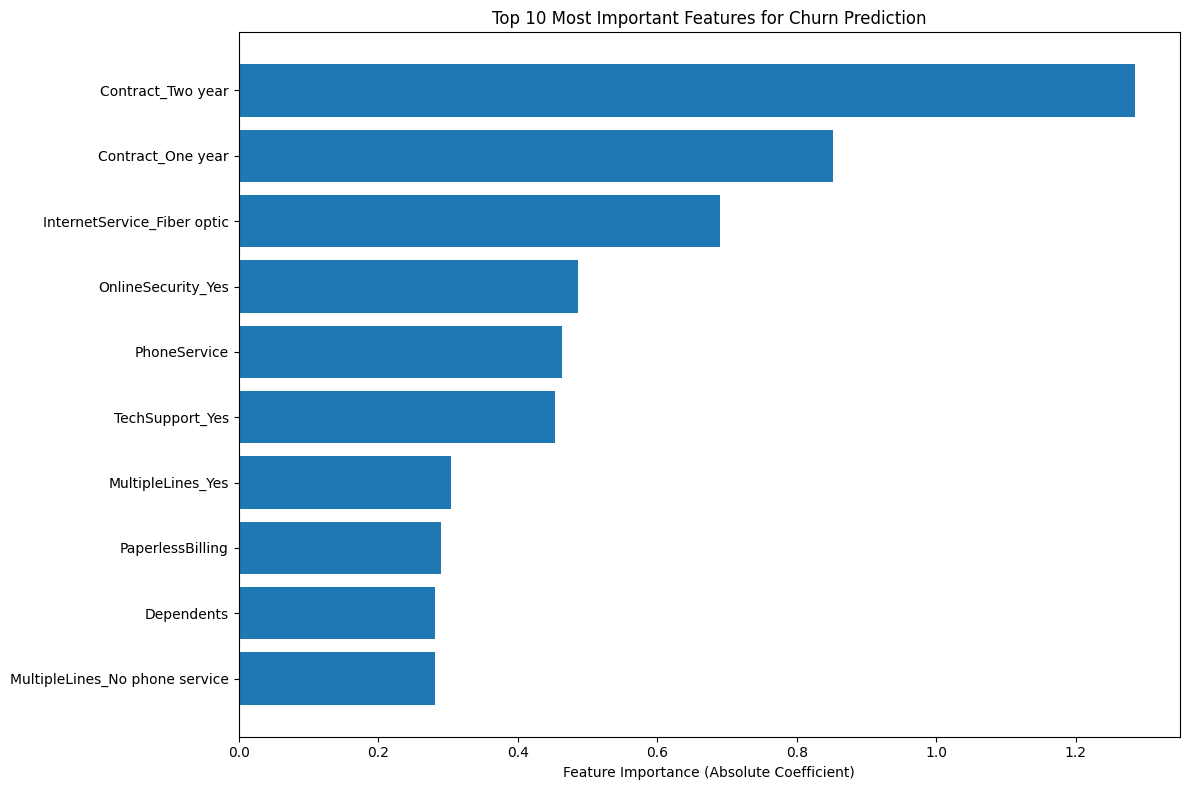

In [102]:
# Feature Importance Analysis

# Get feature importance (coefficients for Logistic Regression)
feature_names = X_train.columns
coefficients = final_model.coef_[0]

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(coefficients)
}).sort_values('importance', ascending=False)

# Display top 10 most important features
print("=== TOP 10 MOST IMPORTANT FEATURES ===")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance.head(10)['feature'], feature_importance.head(10)['importance'])
plt.xlabel('Feature Importance (Absolute Coefficient)')
plt.title('Top 10 Most Important Features for Churn Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [103]:
#  Hyperparameter Tuning for Random Forest
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with cross-validation
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("=== HYPERPARAMETER TUNING - RANDOM FOREST ===")
print("Starting Grid Search...")
rf_grid.fit(X_train, y_train)

# Best parameters
print(f"Best Parameters: {rf_grid.best_params_}")
print(f"Best CV F1-Score: {rf_grid.best_score_:.4f}")

# Test tuned model
tuned_rf = rf_grid.best_estimator_
y_pred_tuned = tuned_rf.predict(X_val)
y_proba_tuned = tuned_rf.predict_proba(X_val)

tuned_f1 = f1_score(y_val, y_pred_tuned, pos_label=1)
tuned_auc = roc_auc_score(y_val, y_proba_tuned[:, 1])

print(f"Tuned Random Forest - F1: {tuned_f1:.4f}, AUC: {tuned_auc:.4f}")

=== HYPERPARAMETER TUNING - RANDOM FOREST ===
Starting Grid Search...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best CV F1-Score: 0.6000
Tuned Random Forest - F1: 0.5263, AUC: 0.8343
